# CAB420: Data Generators for Multi-Task Models
Ethan Goan, Dr Simon Denman (s.denman@qut.edu.au)

## Overview 

This is a quick demo on how to make a data generator that includes image augmentation for a multi output model, and may be of used for Q2 of assignment 1C.

### Note

The network we are making doesn't do anything usefull. It has two tasks, but they are both operating on the same data labels, so what it's really doing is the same thing twice. However, this does provide an example of how you can use augmentation in a multi-task model.

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Data

We'll just use Fashion MNIST, and we'll remove most of the samples too as we're using augmentation.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

# remove 95% of the data, just take every 20th element
x_train = x_train[1::20, :, :, :]
print(np.shape(x_train))
y_train = y_train[1::20, :]
print(np.shape(y_train))

(3000, 28, 28, 1)
(3000, 1)


## Creating a Data Generator

We need to create a custom generator for the sequence, which will allow us to output to augmented data and the multiple ground trth labels. 

This has largely been taken from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

If you wish to adapt this, the `__init__` and `__data_generation` methods are the most critical.

In [3]:
# Class for the data generator
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    # Input arguments are as follows:
    #  x:            our X data array that we'll augment
    #  y_one:        y labels for the first output
    #  y_two:        y labels for the second ouput
    #  data_aug:     our data augmentor
    #  batch_size:   the batch size to return from the generator
    #  dim:          size of images
    #  n_channels:   number of image channels
    #  shuffle:      flag to indicate if we should shuffle the data at the end of the epoch
    def __init__(self, x, y_one, y_two, data_aug,                 
                 batch_size=32, dim=(28,28), n_channels=1,
                 shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.x = x
        self.y_one = y_one
        self.y_two = y_two
        self.data_aug = data_aug
        self.list_IDs = np.arange(0, self.x.shape[0])
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            

    # Function to generate data. This will take in a list of sample indicies, and then for each
    # these apply augmentation, and return the augmented data and labels
    #
    # If you wish to check the mechanics out in more detail, you can uncomment the two print lines
    # which will show you the IDs that are being manipulated and help show what's going on - however
    # this will also generate a lot of output text during model training.
    #
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization - creating space for X and y data
#        print(list_IDs_temp)
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # creating a list of empty arrays to hold our data labels. 
        # would initialise this for the number of output labels we have
        y = [np.empty((self.batch_size), dtype=int),
             np.empty((self.batch_size), dtype=int)]

        # Generate data, loop through the list of IDs we have and generate data for each in turn
        for i, ID in enumerate(list_IDs_temp):
#            print(ID)
            # apply random transformation based of our datagen instance
            X[i,] = self.data_aug.random_transform(self.x[ID,])
            # copy our y labels across
            y[0][i,] = self.y_one[ID]
            y[1][i,] = self.y_two[ID]
        return X, y

### Data Augmentation

We can use Keras' existing data augmentor here. We'll deliberately create some fairly wild and extreme augmentation parameters. These parameters are really not suitable, but as a demo it makes it really obvious that augmentation is happening. Just be warned: **we do not recommend that you copy these augmentation parameters**.

In [4]:
# creating image aug with some really wild and extreme augmentation params
# Ad noted above: these params are not suitable, just used to demo it in practice
data_aug = ImageDataGenerator(
                            # rotate between -45, +45 degrees
                            rotation_range=45,
                            # horiziontal shift by +/- 50% of the image width
                            width_shift_range=0.5,
                            # vertical shift by +/- 50% of the image width
                            height_shift_range=0.5,
                            # range for randomly applying a shearing transform
                            shear_range=0.5,
                            # range for zooming
                            zoom_range=0.5,
                            # allow horizontal flips of data
                            horizontal_flip=True,
                            # what value to place in new pixels, given the nature of our data (clothes on a black backround)
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

### Putting it Together

We'll create and test our generator now. Things to note:
* the augmentation object we created above is passed into Data Generator class
* we just pass y_train twice, for the two y variables

In [5]:
# create generator for our dataset
datagen = DataGenerator(x_train, y_train, y_train, data_aug, batch_size=16)

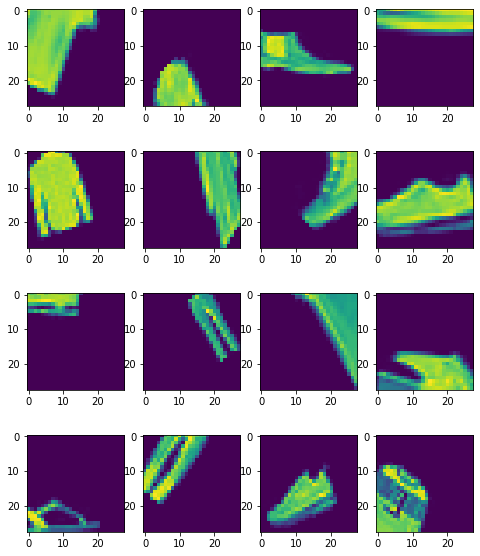

In [6]:
# lets just test how it works
# will just get a random batch from here (just pick the first one)
x_, y_ = datagen[1]
fig = plt.figure(figsize=[8, 10])
for i in range(0, 16):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(x_[i, :,:,0])

As expected, our augmentation is a little extreme. 

We'll now confirm that we have two y outptus, i.e. two set of layers. In our case this should return the same set of labels twice.

In [7]:
print(y_)

[array([6, 3, 9, 7, 6, 3, 7, 7, 7, 1, 6, 5, 5, 1, 7, 2]), array([6, 3, 9, 7, 6, 3, 7, 7, 7, 1, 6, 5, 5, 1, 7, 2])]


## Using the DataGenerator in Model Training

We'll now train a simple model. This will be a very simple model, using a similar architecture to the second lecture example from week 10. Critically, it will have two outputs, but both outputs will be doing the same task. 

Again this isn't a demo of a proper model or multi-task learning. Is just here to demo that the image gen is working properly with multiple outputs.

In [8]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = layers.Flatten()(x)
x1 = layers.Dense(64, activation='relu')(x)
output_1 = layers.Dense(10, name='output1')(x1)
x2 = layers.Dense(64, activation='relu')(x)
output_2 = layers.Dense(10, name='output2')(x2)

model_cnn = keras.Model(inputs=inputs, outputs=[output_1, output_2], name='fmnist_dummy_model')
model_cnn.summary()

Model: "fmnist_dummy_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 8)    80          img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 16)   1168        max_pooling2d[0][0]              
_________________________________________________________________________________

The key aprt now is that we pass to `fit` our data generator we created above, `datagen`.

Note that the validation data is not from a generator, but is the regular test set (with y_test duplicated for the two outputs.

In [9]:
model_cnn.compile(loss=[keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        keras.losses.SparseCategoricalCrossentropy(from_logits=True)],
              optimizer=keras.optimizers.RMSprop())
model_cnn.fit(datagen,
          epochs=10,
          validation_data=(x_test, [y_test, y_test]))

Epoch 1/10
187/187 [==============================] - 3s 11ms/step - loss: 4.5574 - output1_loss: 2.2825 - output2_loss: 2.2749 - val_loss: 4.0529 - val_output1_loss: 2.0323 - val_output2_loss: 2.0206
Epoch 2/10
187/187 [==============================] - 2s 8ms/step - loss: 4.3006 - output1_loss: 2.1513 - output2_loss: 2.1492 - val_loss: 3.9415 - val_output1_loss: 1.9789 - val_output2_loss: 1.9626
Epoch 3/10
187/187 [==============================] - 2s 8ms/step - loss: 4.2046 - output1_loss: 2.1048 - output2_loss: 2.0998 - val_loss: 3.5288 - val_output1_loss: 1.7699 - val_output2_loss: 1.7589
Epoch 4/10
187/187 [==============================] - 2s 9ms/step - loss: 4.0698 - output1_loss: 2.0380 - output2_loss: 2.0318 - val_loss: 3.1843 - val_output1_loss: 1.5917 - val_output2_loss: 1.5926
Epoch 5/10
187/187 [==============================] - 2s 9ms/step - loss: 3.9799 - output1_loss: 1.9897 - output2_loss: 1.9903 - val_loss: 3.1902 - val_output1_loss: 1.5922 - val_output2_loss: 1.5980

We can see from above, our model trains. In this instance you really can ignore the losses - we're not training a serious model here (the data augmentation is too extreme, and we have the same task twice), but hopefully from the above you can see you could do this for real.